In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import GPyOpt
import GPy
from numba import jit

import time

from bo import bayesianOptimization
from acquisitions import ei, rollout_mcmc, policy_rollout, policy_naive
from utils import minimize, gap, generate_init, fit

In [3]:
norm = True
objective_true  = GPyOpt.objective_examples.experiments2d.branin(normalized = norm)               # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.branin(sd = 0.0001,normalized = norm)         # noisy version
bounds = objective_true.bounds     

In [4]:
bounds

[(0, 1), (0, 1)]

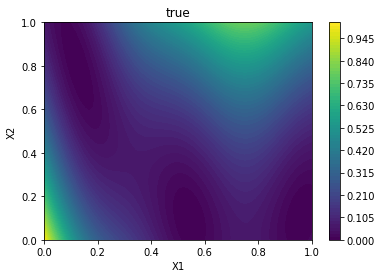

In [5]:
grid = 100
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))
_Y = objective_true.f(_X)

plt.figure()    
plt.contourf(X1, X2, _Y.reshape((grid,grid)),grid)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("true")
plt.show()

In [6]:
fmin = objective_true.f(minimize(objective_true.f,bounds,grid=500))[0][0]

In [7]:
fmin

5.668025434643928e-07

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fad0d722278>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7fad0d722198>]}

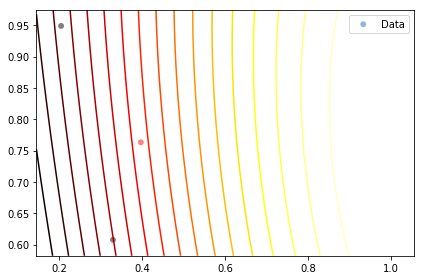

In [8]:
#%%prun
X = generate_init(bounds,5) 
Y = objective_true.f(X)

kernel = GPy.kern.RBF(2, ARD=False)
model = fit(X,Y,kernel)

model.plot()

In [11]:
grid = 10
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))

h=4
N_q=1
n_sample = 5
_Y = np.array([])
for i in range(_X.shape[0]):
    print(i)
    x = _X[i:i+1]
    y = rollout_mcmc(x = x,
                        bounds = bounds,
                        func_policy=policy_rollout, 
                        depth_h = h, 
                        _queries = X, 
                        _values = Y,
                        n_sample = n_sample,
                        decay_rate = .9,
                        length_scale = 0.2)
    _Y = np.concatenate([_Y,y[0]])
_Y = _Y.T

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


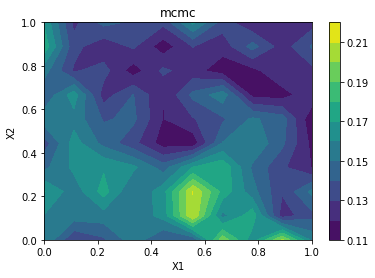

In [12]:
plt.figure()    
plt.contourf(X1, X2, _Y.reshape((grid,grid)),grid)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("mcmc")
plt.show()

## bench marks

In [24]:
obj_f = objective_true.f
kernel = GPy.kern.RBF(2, ARD=True)
seed = 2
np.random.seed(seed=seed)

h=3
N_q=5
N = 10
n_sample = 5
init_n=0
initpoints = [np.array([[0.5, 0.5]]), np.array([[0.1, 0.9]]), np.array([[0.8, 0]]), np.array([[0.2, 0.6]])]

n = 4
queriesei = {}
valuesei={}
gapsei=[]
queriesnaivemcmc = {}
valuesnaivemcmc={}
gapsnaivemcmc=[]
queriesmcmc = {}
valuesmcmc={}
gapsmcmc=[]


for i in range(n):
    print("n_ei",i)
    initpoint = initpoints[i]
    _query, _value = bayesianOptimization(obj_f,
                                          ei,
                                          None,
                                          bounds,
                                          depth_h = h,
                                          N = N,
                                          initial_n=init_n,
                                          initpoint = initpoint,
                                          N_q = N_q,
                                          n_sample = n_sample,
                                          ARD_Flag = False,
                                          length_scale = 0.2
                                          )
    queriesei[i] = _query
    valuesei[i] = _value
    gapsei.append(gap(_value, fmin=fmin))

for i in range(n):
    print("naivemcmc", i)
    initpoint = initpoints[i]
    _query, _value = bayesianOptimization(obj_f,
                                          rollout_mcmc,
                                          policy_naive,
                                          bounds,
                                          depth_h = h,
                                          N = N,
                                          initial_n=init_n,
                                          initpoint = initpoint,
                                          N_q = N_q,
                                          n_sample = n_sample,
                                          decay_rate=.9,
                                          ARD_Flag = False,
                                          length_scale = 0.2
                                          )
    queriesnaivemcmc[i] = _query
    valuesnaivemcmc[i] = _value
    gapsnaivemcmc.append(gap(_value, fmin=fmin))

for i in range(n):
    print("mcmc", i)
    initpoint = initpoints[i]
    _query, _value = bayesianOptimization(obj_f,
                                          rollout_mcmc,
                                          policy_rollout,
                                          bounds,
                                          depth_h = h,
                                          N = N,
                                          initial_n=init_n,
                                          initpoint = initpoint,
                                          N_q = N_q,
                                          n_sample = n_sample,
                                          decay_rate=.9,
                                          ARD_Flag = False,
                                          length_scale = 0.2
                                          )
    queriesmcmc[i] = _query
    valuesmcmc[i] = _value
    gapsmcmc.append(gap(_value, fmin=fmin))

n_ei 0
0
1
2
3
4
5
6
7
8
9
n_ei 1
0
1
2
3
4
5
6
7
8
9
n_ei 2
0
1
2
3
4
5
6
7
8
9
n_ei 3
0
1
2
3
4
5
6
7
8
9
naivemcmc 0
0
1
2
3
4
5
6
7
8
9
naivemcmc 1
0
1
2
3
4
5
6
7
8
9
naivemcmc 2
0
1
2
3
4
5
6
7
8
9
naivemcmc 3
0
1
2
3
4
5
6
7
8
9
mcmc 0
0
1
2
3
4
5
6
7
8
9
mcmc 1
0
1
2
3
4
5
6
7
8
9
mcmc 2
0
1
2
3
4
5
6
7
8
9
mcmc 3
0
1
2
3
4
5
6
7
8
9


In [25]:
import pickle
with open('./data/191220rollout_mcmc_h3n5r5l1_opt1retry.pickle', mode='wb') as f:
     pickle.dump(queriesei, f)
with open('./data/191220rollout_mcmc_h3n5r5l1_opt1retry.pickle', mode='wb') as f:
     pickle.dump(queriesnaivemcmc, f)
with open('./data/191220rollout_mcmc_h3n5r5l1_opt1retry.pickle', mode='wb') as f:
     pickle.dump(queriesmcmc, f)

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

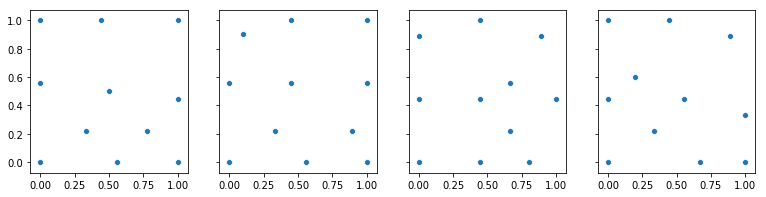

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharex=True,sharey=True,figsize=(13,3))

sns.scatterplot(queriesei[0][:,0],queriesei[0][:,1], ax =ax1)
sns.scatterplot(queriesei[1][:,0],queriesei[1][:,1], ax =ax2)
sns.scatterplot(queriesei[2][:,0],queriesei[2][:,1], ax =ax3)
sns.scatterplot(queriesei[3][:,0],queriesei[3][:,1], ax =ax4)

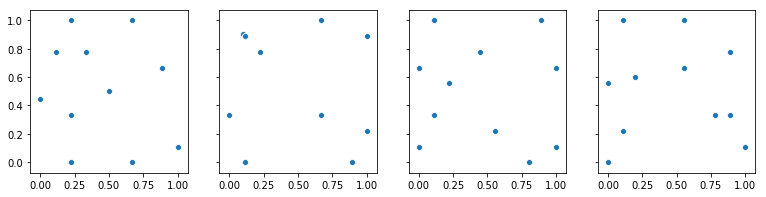

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharex=True,sharey=True,figsize=(13,3))

sns.scatterplot(queriesnaivemcmc[0][:,0],queriesnaivemcmc[0][:,1], ax =ax1)
sns.scatterplot(queriesnaivemcmc[1][:,0],queriesnaivemcmc[1][:,1], ax =ax2)
sns.scatterplot(queriesnaivemcmc[2][:,0],queriesnaivemcmc[2][:,1], ax =ax3)
sns.scatterplot(queriesnaivemcmc[3][:,0],queriesnaivemcmc[3][:,1], ax =ax4)

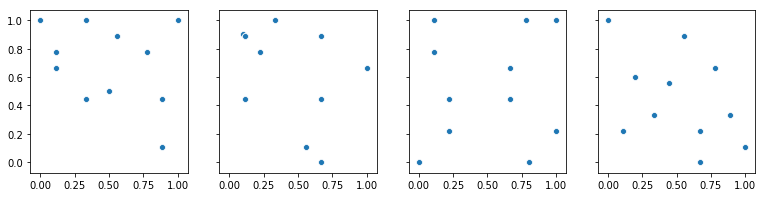

In [29]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharex=True,sharey=True,figsize=(13,3))

sns.scatterplot(queriesmcmc[0][:,0],queriesmcmc[0][:,1], ax =ax1)
sns.scatterplot(queriesmcmc[1][:,0],queriesmcmc[1][:,1], ax =ax2)
sns.scatterplot(queriesmcmc[2][:,0],queriesmcmc[2][:,1], ax =ax3)
sns.scatterplot(queriesmcmc[3][:,0],queriesmcmc[3][:,1], ax =ax4)

In [30]:
print("meanEI", np.mean(gapsei))
print("meanNAIVEMCMC", np.mean(gapsnaivemcmc))
print("meanMCMC", np.mean(gapsmcmc))

meanEI 0.25631274995875186
meanNAIVEMCMC 0.6824624091628584
meanMCMC 0.7920686834769977


In [22]:
print(gapsei)
print(gapsnaivemcmc)
print(gapsmcmc)

[0.9492831535382793, 0.0, 0.051558051492213104, 0.9787931643639997]
[0.9685503519076322, 0.1711153862999396, 0.8965877779409532, 0.9745311255638173]
[0.9685503519076322, 0.5595233778021651, 0.9466048836952851, 0.9745311255638173]


In [31]:
queriesei

{0: array([[0.5       , 0.5       ],
        [0.        , 0.        ],
        [0.        , 1.        ],
        [1.        , 0.        ],
        [1.        , 1.        ],
        [1.        , 0.44444444],
        [0.55555556, 0.        ],
        [0.44444444, 1.        ],
        [0.        , 0.55555556],
        [0.77777778, 0.22222222],
        [0.33333333, 0.22222222]]), 1: array([[0.1       , 0.9       ],
        [0.        , 0.        ],
        [0.88888889, 0.22222222],
        [1.        , 1.        ],
        [0.44444444, 0.55555556],
        [0.44444444, 1.        ],
        [0.        , 0.55555556],
        [0.55555556, 0.        ],
        [1.        , 0.55555556],
        [0.33333333, 0.22222222],
        [1.        , 0.        ]]), 2: array([[0.8       , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.88888889],
        [0.88888889, 0.88888889],
        [0.44444444, 0.44444444],
        [1.        , 0.44444444],
        [0.44444444, 1.        ],
   